# HD posteriors: "easy mode"


This notebook explores the posterior distributions derived for $K$ GW sources where we use **just the Earth terms** in the modelling and try to infer solely the elements of $\theta_{\rm GW}$

---

# Setup 

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import json 
import pandas as pd 
import numpy as np 
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

In [7]:
from system_parameters import SystemParameters
from pulsars import Pulsars
from synthetic_data import SyntheticData
from model import LinearModel
from kalman_filter import KalmanFilter
from bilby_wrapper import BilbySampler
from priors import bilby_priors_dict
def get_point_estimate_of_likelihood(h,measurement_model,seed,num_gw_sources):


    P   = SystemParameters(h=h,σp=None,σm=1e-11,use_psr_terms_in_data=True,measurement_model=measurement_model,seed=seed,num_gw_sources=num_gw_sources) # define the system parameters as a dict. Todo: make this a class
    PTA = Pulsars(P)                                       # setup the PTA
    data = SyntheticData(PTA,P)                            # generate some synthetic data

    #Define the model 
    model = LinearModel(P)

    #Initialise the Kalman filter
    KF = KalmanFilter(model,data.f_measured,PTA)

    #Run the KF once with the correct parameters.
    #This allows JIT precompile

    init_parameters_optimal, priors_optimal = bilby_priors_dict(PTA,P,set_state_parameters_as_known=True,set_measurement_parameters_as_known=True)
    optimal_parameters = priors_optimal.sample(1)
    model_likelihood = KF.likelihood(optimal_parameters)



    return model_likelihood



from plotting import plot_custom_corner
def plot_results(path,seed,num,ranges=None):




    if num > 1:
        generator = np.random.default_rng(seed)
        Ω = generator.uniform(low = 1e-7,high=9e-7,size=num)
        Φ0 = generator.uniform(low = 0.0,high=np.pi/2,size=num)
        ψ = generator.uniform(low = 0.0,high=np.pi,size=num)
        ι = np.ones(num)
        δ = generator.uniform(low = 0.0,high=np.pi/2,size=num)
        α = generator.uniform(low = 0.0,high=np.pi,size=num)
        h = np.ones(num) * 5e-15

    else:
        Ω = np.array([5e-7])
        Φ0 = np.array([0.20])
        ψ = np.array([2.50])
        ι = np.array([1.0])
        δ = np.array([1.0])
        α = np.array([1.0])
        h = np.array([5e-15])



    injection_parameters = np.array([Ω,Φ0,ψ,ι,δ,α,h]).flatten()



    omegas = [f"omega_gw_{i}" for i in range(num)]
    phis   = [f"phi0_gw_{i}" for i in range(num)]
    psis   = [f"psi_gw_{i}" for i in range(num)]
    iotas  = [f"iota_gw_{i}" for i in range(num)]
    deltas = [f"delta_gw_{i}" for i in range(num)]
    alphas = [f"alpha_gw_{i}" for i in range(num)]
    hs     = [f"h_{i}" for i in range(num)]
    variables_to_plot = np.array([omegas,phis,psis,iotas,deltas,alphas,hs]).flatten()



    
    labels = None
    axes_scales = None



    #corner plot is too big, just plot omegas
    if num > 5:
        injection_parameters = np.array([Ω]).flatten()
        variables_to_plot = np.array([omegas]).flatten()
        ranges = [(1e-7,9e-7) for i in range(num)]



    #Corner plot of GW parameters
    model_evidence = plot_custom_corner(path,
                    np.array(variables_to_plot),
                    labels,
                    injection_parameters,
                    ranges,
                    axes_scales,
                    savefig=None,
                    smooth=True,smooth1d=True)



    null_likelihood = get_point_estimate_of_likelihood(h,'null',seed,num)
    print(model_evidence, null_likelihood)


    bayes_factor = model_evidence - null_likelihood
    print("The Bayes factor is: ", bayes_factor)

# k = 20

Extracting data from file:  /Users/t1/github_repos/StateSpacePTA/data/nested_sampling/01floor/V3_floor_earth_k_20_seed_1255_result.json
The evidence is: 586136.2418429477
The number of samples is: 11897
Variable/Injection/Median
omega_gw_0 1.355246006595488e-07 1.849831524253065e-07
omega_gw_1 4.802113543543518e-07 4.80253889402432e-07
omega_gw_2 2.2585466980693115e-07 4.873966808036802e-07
omega_gw_3 1.5897108588179859e-07 4.4541428647582685e-07
omega_gw_4 6.486253542259353e-07 3.574830426198949e-07
omega_gw_5 7.00444976920631e-07 4.8813380857131e-07
omega_gw_6 5.65928352650522e-07 1.340064273012859e-07
omega_gw_7 3.3033849496829886e-07 3.198524439390242e-07
omega_gw_8 7.052726489913581e-07 3.393007017923508e-07
omega_gw_9 1.3656388560867228e-07 6.075736508863285e-07
omega_gw_10 2.5228353948152786e-07 2.4372136078465127e-07
omega_gw_11 3.488100120599063e-07 1.2910556371097377e-07
omega_gw_12 7.852935056481316e-07 1.7168945743029418e-07
omega_gw_13 8.305108711188102e-07 2.5879698085051

INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1255
INFO:root:Multiple GW sources requested. Overwriting default GW parameters and randomly sampling
INFO:root:You are assigning the σp terms randomly
INFO:root:You are including the PSR terms in your synthetic data generation
INFO:root:You are using just the null measurement model
INFO:root:Setting the bilby priors dict
INFO:root:Setting fully informative priors on GW parameters
INFO:root:Setting fully informative priors on PSR parameters


586136.2418429477 585592.3055393265
The Bayes factor is:  543.936303621158


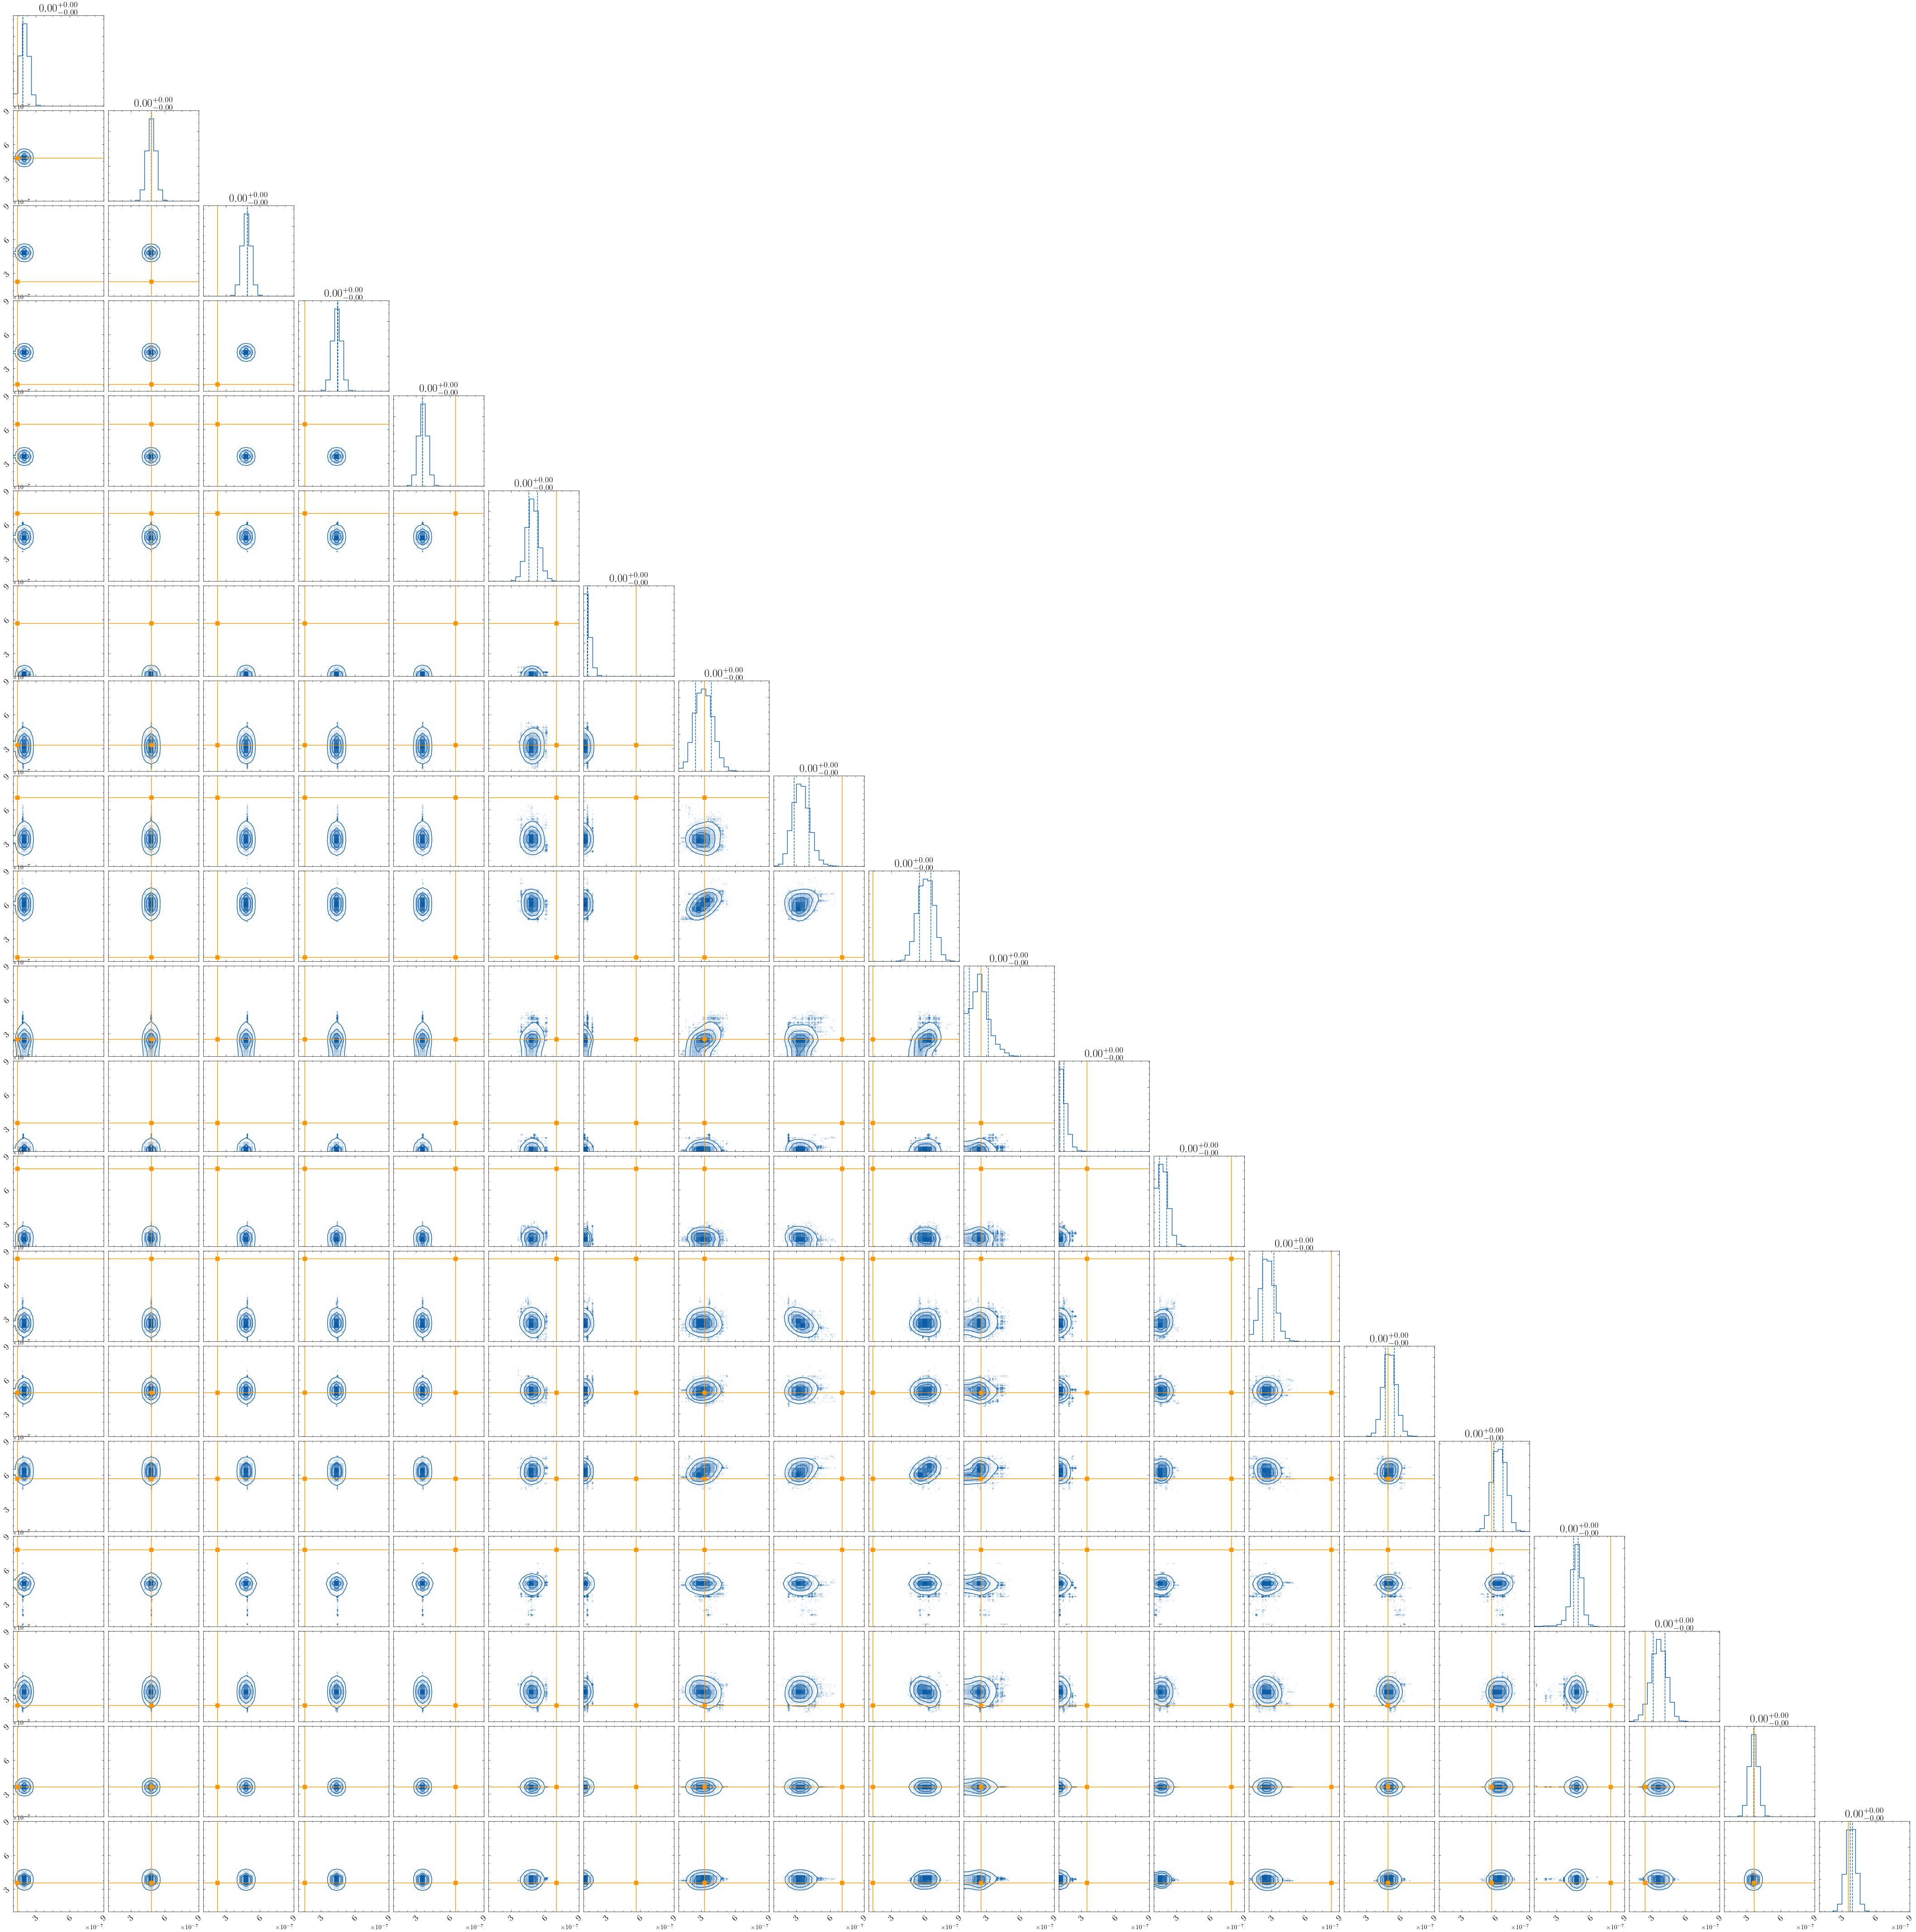

In [8]:
ff = '/Users/t1/github_repos/StateSpacePTA/data/nested_sampling/01floor/V3_floor_earth_k_20_seed_1255_result.json'
plot_results(ff,1255,20)